<a href="https://colab.research.google.com/github/niteshctrl/ml_projects/blob/master/StackOverflow_Tags_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

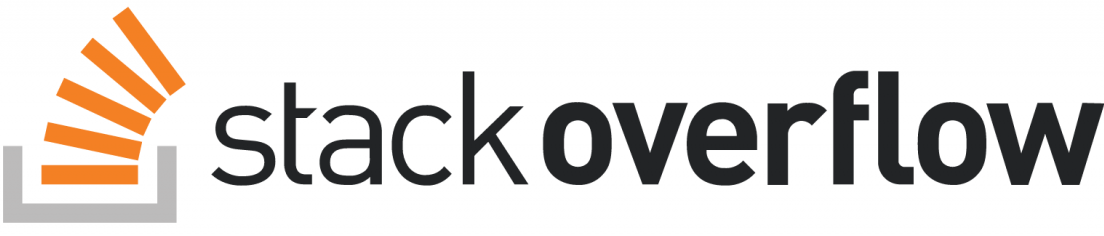
Image Credit: www.stackoverflow.com

# Table of Contents

1. [**Data Set Up**](#1-Data-Set-Up)
2. [**Data Cleaning - I**](#1-Data-Cleaning-I)

# 0 Introduction

### `Task:`
Predict the tags (a.k.a. keywords, topics, summaries), given only the question text and its title. The dataset contains content from disparate stack exchange sites, containing a mix of both technical and non-technical questions.

### `Evaluation Metric:`
The evaluation metric for this project is Mean F1-Score.  The F1 score, commonly used in information retrieval, measures accuracy using the statistics precision P and recall R. Precision is the ratio of true positives (TP) to all predicted positives (TP + FP). Recall is the ratio of true positives to all actual positives (TP + FN). The F1 score is given by:

> F1=2PR / (P + R)

The F1 metric weights recall and precision equally, and a good retrieval algorithm will maximize both precision and recall simultaneously. Thus, moderately good performance on both will be favored over extremely good performance on one and poor performance on the other.

The tag predicted must be an exact match, regardless of whether the tags are synonyms. 

* **Why aren't synonyms counted?**

1. Giving out a list of candidate synonyms is a potential source of leakage
2. Synonyms are subjective, and there are "subjectively many" synonyms for a given tag
3. Equally penalized for predicting a synonym of a correct tag, so the task can be framed as not only predicting a tag, but also modeling the distribution(s) of potential synonyms

## Data Description:
Train.csv contains 4 columns: Id,Title,Body,Tags

1. Id - Unique identifier for each question
2. Title - The question's title
3. Body - The body of the question
4. Tags - The tags associated with the question (all lowercase, should not contain tabs '\t' or ampersands '&')
---

Ref : https://medium.com/datadriveninvestor/predicting-tags-for-the-questions-in-stack-overflow-29438367261e

<a id='data'></a>
# 1 Data Set Up

In [1]:
# Connecting Google Drive

from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/3wFkPyw-2FuEv42KTyeTq1igAd4-pyp6axwEWuovcpe-HmbZ5T-w6bw
Mounted at /content/gdrive/


In [2]:
# Installing library for expanding contractions during Preprocessing

!pip install contractions

     |████████████████████████████████| 245kB 3.7MB/s 
     |████████████████████████████████| 317kB 8.2MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81701 sha256=f72149ebfb820b8f92cf215d58aaa8c0afa863ec316d66bd6ff0d7e0d1de54a1
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick


In [18]:
# Importing Libraries

import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Preprocessing Libraries
import re
import nltk
import contractions                     # Use pycontractions in future uses
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

# Featurization Libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Modeling Libraries
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier

# Metrics Libraries
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score


In [4]:
# Downloading Required NLTK data

nltk.download('punkt')          # For Tokenization
nltk.download('stopwords')      # Set of Stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
pd.set_option('display.max_colwidth', 100)

In [6]:
# Extracting the ZIP data files in Google Drive
"""
!unzip /content/gdrive/My\ Drive/datasets/stacko/Train.zip -d /content/gdrive/My\ Drive/datasets/stacko/
!unzip /content/gdrive/My\ Drive/datasets/stacko/Test.zip -d /content/gdrive/My\ Drive/datasets/stacko"""

'\n!unzip /content/gdrive/My\\ Drive/datasets/stacko/Train.zip -d /content/gdrive/My\\ Drive/datasets/stacko/\n!unzip /content/gdrive/My\\ Drive/datasets/stacko/Test.zip -d /content/gdrive/My\\ Drive/datasets/stacko'

In [7]:
# Loading the data from Google Drive into PANDAS Dataframe

train_df = pd.read_csv('/content/gdrive/My Drive/datasets/stacko/Train.csv')

# 2 Data Cleaning I

1. Duplicate Removal
2. NULL Values Check
3. Empty String Check

## 2.1 Duplicates Removal

In [8]:
# View of the DataFrame

train_df.head()

,Id,Title,Body,Tags
0,1,How to check if an uploaded file is an image without mime type?,"<p>I'd like to check if an uploaded file is an image file (e.g png, jpg, jpeg, gif, bmp) or anot...",php image-processing file-upload upload mime-types
1,2,How can I prevent firefox from closing when I press ctrl-w,"<p>In my favorite editor (vim), I regularly use ctrl-w to execute a certain action. Now, it quit...",firefox
2,3,R Error Invalid type (list) for variable,"<p>I am import matlab file and construct a data frame, matlab file contains two columns with and...",r matlab machine-learning
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply cannot find the answer myself :( </p>\n\n<p>Basica...",c# url encoding
4,5,How to modify whois contact details?,"<pre><code>function modify(.......)\n{\n $mcontact = file_get_contents( ""https://test.httpapi.c...",php api file-get-contents


In [9]:
# Check for duplicates

train_df[['Title','Body','Tags']].duplicated().value_counts()

False    4206314
True     1827881
dtype: int64

---

> **There are a significant number of 'True' values implying 1827881 duplicate rows.**

---
---

In [10]:
# Duplicate Removal

train_no_dup = train_df[['Title','Body','Tags']].drop_duplicates(ignore_index=True)
train_no_dup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4206314 entries, 0 to 4206313
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Title   object
 1   Body    object
 2   Tags    object
dtypes: object(3)
memory usage: 96.3+ MB


---

> **We are now left with only 4206314 (4.2M) rows which is a reduction of ~30% data rows!!**

---
---

## 2.2 NULL Values Removal

In [11]:
# NULL Value Check

for column in train_no_dup.columns:
    print("NULL Value check for Column '{}' is\n {}\n".format(column, train_no_dup[column].isnull().value_counts()))

NULL Value check for Column 'Title' is
 False    4206314
Name: Title, dtype: int64

NULL Value check for Column 'Body' is
 False    4206314
Name: Body, dtype: int64

NULL Value check for Column 'Tags' is
 False    4206307
True           7
Name: Tags, dtype: int64



---

> **Observe there exists 7 Null Values in 'Tags' column. We will be investigating it further.**

---
---

In [12]:
# View of rows with Null Values in 'Tags' column

train_no_dup[train_no_dup['Tags'].isnull()]

,Title,Body,Tags
850166,Do we really need NULL?,"<blockquote>\n <p><strong>Possible Duplicate:</strong><br>\n <a href=""http://stackoverflow.com...",NaN
971049,Page cannot be null. Please ensure that this operation is being performed in the context of an A...,<p>I get this error when i remove dynamically telerik raddock and raddock zone controls and add...,NaN
1347475,How do Germans call null,"<p>In german null means 0, so how do they call null (like null reference) ?</p>\n",NaN
1722409,"What is the difference between NULL and ""0""?","<p>What is the difference from NULL and ""0""?</p>\n\n<p>Example:</p>\n\n<pre><code>return NULL;\n...",NaN
2241942,a bit of difference between null and space,<p>I was just reading this quote</p>\n\n<blockquote>\n <p>And don't tell me there isn't one bit...,NaN
2647070,Handle NullObjects,<p>I have done quite a bit of research on best ways to deal with null objects.\nThe best I came ...,NaN
3241110,Find all values that are not null and not in another table,<p>I am running into a problem which results in an ORA-01722 error. I have a table that contain...,NaN


---

> **Observe that the corresponding title with Tags = NaN contain the word 'NULL' asking for some information that is related to NULL values. We now investigate further if there exists 'NULL' as a tag to some question.**

---
---

In [13]:
# Checking if Null is a tag

print((train_no_dup['Tags'] == 'Null').value_counts())
print((train_no_dup['Tags'] == 'NULL').value_counts())
print((train_no_dup['Tags'] == 'null').value_counts())
print((train_no_dup['Tags'] == 'none').value_counts())

False    4206314
Name: Tags, dtype: int64
False    4206314
Name: Tags, dtype: int64
False    4206314
Name: Tags, dtype: int64
False    4206314
Name: Tags, dtype: int64


--- 
> **Since none of the tags contain Null as a tag, removing the above seven questions from our data would serve as it's a very small fraction of the entire dataset.**

---
---

In [14]:
# Removing Rows with NULL value in Tags
train_no_dup = train_no_dup[train_no_dup['Tags'].notnull()]


# Final Check if Null has been removed successfully
print(train_no_dup['Tags'].isnull().value_counts())

False    4206307
Name: Tags, dtype: int64


# 3 Exploratory Data Analysis

1. Univariate Analysis
2. Multivariate Analysis

In [15]:
train_no_dup.head()

,Title,Body,Tags
0,How to check if an uploaded file is an image without mime type?,"<p>I'd like to check if an uploaded file is an image file (e.g png, jpg, jpeg, gif, bmp) or anot...",php image-processing file-upload upload mime-types
1,How can I prevent firefox from closing when I press ctrl-w,"<p>In my favorite editor (vim), I regularly use ctrl-w to execute a certain action. Now, it quit...",firefox
2,R Error Invalid type (list) for variable,"<p>I am import matlab file and construct a data frame, matlab file contains two columns with and...",r matlab machine-learning
3,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply cannot find the answer myself :( </p>\n\n<p>Basica...",c# url encoding
4,How to modify whois contact details?,"<pre><code>function modify(.......)\n{\n $mcontact = file_get_contents( ""https://test.httpapi.c...",php api file-get-contents


In [16]:
train_no_dup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4206307 entries, 0 to 4206313
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Title   object
 1   Body    object
 2   Tags    object
dtypes: object(3)
memory usage: 128.4+ MB


---
**Observations**:
1. Number of rows = 4206307 ( 4.2M)
---

In [52]:
# Total number of datapoints left

datapoints = 4206307

In [93]:
# WordCloud function

def _plot_wcloud(list_words):
    # Ref: https://towardsdatascience.com/simple-wordcloud-in-python-2ae54a9f58e5
    wc = WordCloud(width=1000, height=700, stopwords = {'dummy'})
    wc.generate(list_words)
    
    plt.figure(figsize=(10,6))
    plt.imshow(wc)
    plt.axis('off')
    plt.show()

## 3.1 Univariate Analysis

In [50]:
# Calculate number of spaces in each title which will define it's Word Count

title_word_length = []
for i in tqdm(range(datapoints)):
    length_title.append(train_no_dup['Title'].iloc[i].count(" ") + 1)

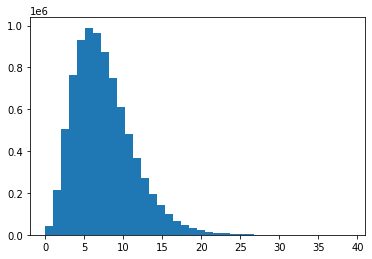

In [51]:
# Distribution of Title Word length

plt.hist(length_title, bins = 38)
plt.show()

---
> **Most of the titles are in the range of 5-10 words as evident from the distribtion plot. Since, the body is composed of both natural text and programming code, we will skip this analysis on 'Body' as codes could be very lengthly and non-meaningful for analysis**

---
---

In [53]:
# Number of tags in each row of data

row_tag_count = []
for i in tqdm(range(datapoints)):
    row_tag_count.append(train_no_dup['Tags'].iloc[i].count(" ") + 1)

In [55]:
pd.Series(row_tag_count).value_counts()

3    1206157
2    1111706
4     814996
1     568290
5     505158
dtype: int64

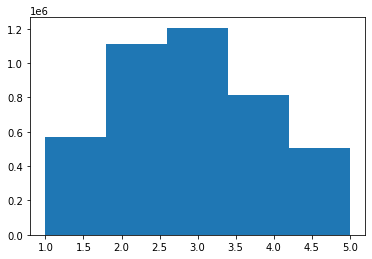

In [57]:
# Distribution of tag counts in each row

plt.hist(row_tag_count, bins = 5)
plt.show()

---
> **Minimum number of tag associated to a row is 1 and maximum is 5. Most  of the rows have 3 tags followed by 2 tags and then 4 tags.**

---
---

In [59]:
# Unique tags and their frequency of occurence

tags = []
for i in train_no_dup['Tags']:
    try:
        tags.extend(i.split())
    except:
        continue

print(pd.Series(tags).value_counts())

c#                    331505
java                  299414
php                   284103
javascript            265423
android               235436
                       ...  
imapclient                 1
fanotify                   1
windows-automation         1
jzkit                      1
r7rs                       1
Length: 42048, dtype: int64


---
> **There are 42048 unique tags in total.**

---
---

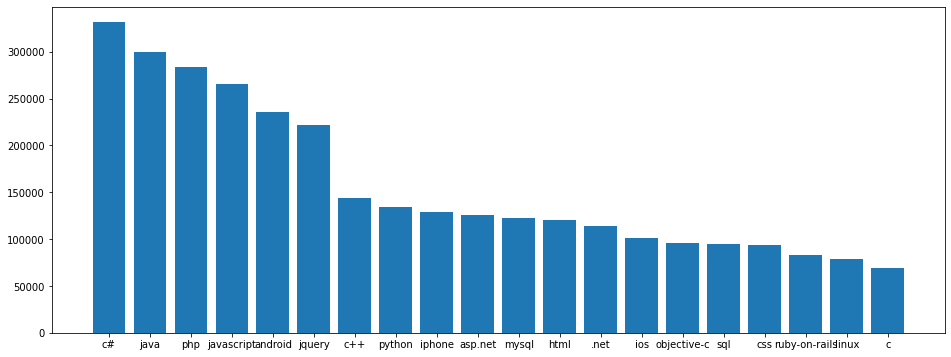

In [82]:
# Bar Plot of top 20 tags

plt.figure(figsize=(16,6))
plt.bar(pd.Series(tags).value_counts().index.values[:20], pd.Series(tags).value_counts()[:20])
plt.show()

In [90]:
# Prepare a single string of tags to plot WordCloud

tags_str = ' '.join(s for s in tags)

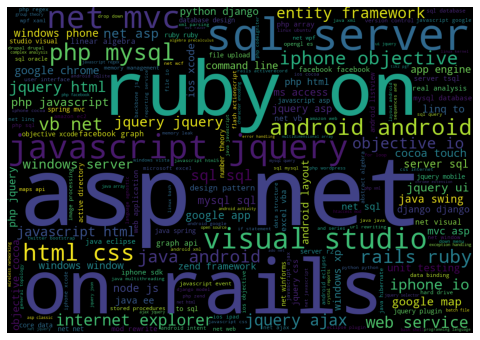

In [94]:
_plot_wcloud(tags_str)

---
> **This looks ambigous. c#, java and many more, the highest occuring tags are dominated by other tags in the word cloud whose occurance is lower than them.**

TBD :: WordCloud of Title and Body to see if there is any existence of correlation b/w them and Tags; after resolving the above ambiguity.

---
---


In [ ]:
# Top 30 Tag strings and their frequency of occurence

train_no_dup['Tags'].value_counts()[0:30]

android                   35794
php                       21957
jquery                    19842
javascript                17955
javascript jquery         17923
java                      17296
c#                        16318
python                    11920
php mysql                 11501
c++                       11081
mysql                     10792
html css                   9651
iphone                     8603
asp.net                    8105
ruby-on-rails              7060
c# asp.net                 7056
java android               6336
c                          6186
css                        6132
c# .net                    4349
r                          4320
git                        4152
javascript html            4073
iphone objective-c         4071
javascript jquery html     3713
sql                        3686
objective-c                3641
ruby                       3573
mysql sql                  3509
asp.net-mvc                3442
Name: Tags, dtype: int64

---

> **Observe that most occuring tags strings are of word(tag) length 1 and hence label(tag) dependency is something which can be ignored in this data as the tags are fairly independent.**

---
---

## 3.2 Multivariate Analysis

TBD
1. Length of title and body against number of tags.
2. Percentiles and Quantiles.

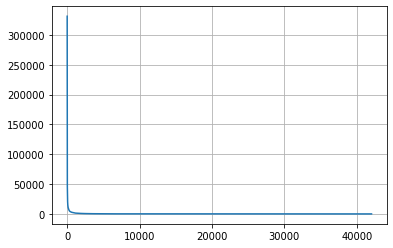

In [ ]:
plt.plot(tags.value_counts().values)
plt.grid()
plt.show()

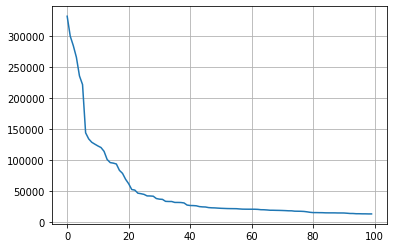

In [ ]:
plt.plot(tags.value_counts().values[0:100])
plt.grid()
plt.show()

# 3 Data Cleaning - II and Preprocessing

1. HTML tags Removal
2. Punctuation Removal
3. Stopwords Removal
4. Stemming(This auto lowercases the words) or Lemmitization
5. Convert to Lowercase
7. Expanding Contractions
8. Treat numbers

In [ ]:
# Preprocessing Functions

"""
def _html_tag_remover(sentence):
    # Ref: https://medium.com/@jorlugaqui/how-to-strip-html-tags-from-a-string-in-python-7cb81a2bbf44
    clean = re.compile('<.*?>')
    return re.sub(clean, ' ', sentence).strip()


def _expand_contractions(sentence):
    # Ref: https://medium.com/@lukei_3514/dealing-with-contractions-in-nlp-d6174300876b
    # Ref: https://pypi.org/project/pycontractions/
    # TBD-- Use spaCy or pycontractions
    return contractions.fix(sentence)


def _punc_remover(sentence):
    punctuations = '!?#$%^&*,:\;-_(){}/[]'
    for character in sentence:
        if character in punctuations:
            sentence = sentence.replace(character, " ")
            continue
    return sentence.strip()


def _stop_remover(sentence):
    # Ref: https://www.analyticsvidhya.com/blog/2019/08/how-to-remove-stopwords-text-normalization-nltk-spacy-gensim-python/
    filtered_sentence = ''
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(sentence)
    for token in tokens:
        if token not in stop_words:
            filtered_sentence += token + ' '
    return filtered_sentence.strip()


def _stemmer(sentence): # This automatically converts to lowercase
    stemmed_sentence = ""
    tokens = word_tokenize(sentence) # str.split() can be used for faster result
    # but take a look: https://stackoverflow.com/questions/35345761/python-re-split-vs-nltk-word-tokenize-and-sent-tokenize
    snow = SnowballStemmer('english')
    for token in tokens:
        stemmed_sentence += snow.stem(token) + ' '
    return stemmed_sentence.strip()


def _lemmatizer(sentence):
    pass


def _treat_numbers(sentence):
    pass
"""

In [ ]:
# Faster Preprocessing without function calls
datapoints = len(train_no_dup)

def _preprocess(train_list):
    """
    Arguments:
    train_list --- A list of unprocessed strings

    Returns:
    filtered_sentences --- A list of processed strings
    """

    filtered_sentences = []
    punctuations = '!?#$%^&*,:\;-_(){}/[]'
    stop_words = set(stopwords.words('english'))
    snow = SnowballStemmer('english')

    for i in tqdm(range(len(train_list))):
        sentence = train_list[i]
        clean = re.compile('<.*?>')
        sentence = re.sub(clean, ' ', sentence).strip() # HTML Removal
        sentence = contractions.fix(sentence)           # Expanding Contractions
        tokens = word_tokenize(sentence)
        temp = ''
        for token in tokens:
            if token not in punctuations:               # Punctuation Removal
                if token not in stop_words:             # Stopword Removal
                    temp += snow.stem(token) + ' '      # Stemming
        filtered_sentences.append(temp.strip())

    return filtered_sentences

In [ ]:
# Driving the above function

X_title = _preprocess(train_no_dup['Title'].iloc[0:datapoints])
X_processed = X_title

y = train_no_dup['Tags'].iloc[0:datapoints]

# 4 Featurization

1. Data Splitting
2. Featurization

In [ ]:
def _featurize_split(X_preprocessed, y, y_max_features, cv_size = 0.2):
    """
    Arguments:
    X_preprocessed ---  List of preprocessed text strings to build TfIdf...
    y ---  List of strings with tags to build binary counts
    y_max_features --- Maximum number of tags to consider bases on occurance frequency
    cv_size --- Fraction of input data to split into Cross-Validation set.(default = 0)

    Returns:
    X_featurized --- TfIdf form of each document in the corpus
    Y_featurized --- Binary Bag of Words form of the tags
    vectorizer_tfidf
    """

    # Count Vectorizer for tags(Output Labels)
    vectorizer = CountVectorizer(lowercase=True, binary=True, max_features=y_max_features)
    y_featurized = vectorizer.fit_transform(y)              # Binary Bow

    # Splitting data
    X_train_raw, X_cv_raw, y_train, y_cv = train_test_split\
        (X_preprocessed, y_featurized, test_size = cv_size)                

    # TFIDF Vectorizer for training data(X_train)
    vectorizer_tfidf = TfidfVectorizer()
    X_train = vectorizer_tfidf.fit_transform(X_train_raw)
    X_cv = vectorizer_tfidf.transform(X_cv_raw)

    return X_train, X_cv, y_train, y_cv

In [ ]:
# Driving the above function

X_train, X_cv, y_train, y_cv = _featurize_split(X_processed, y, y_max_features = 75, cv_size = .2)

print(X_train.shape)
print(X_cv.shape)

(3365051, 226214)
(841263, 226214)


In [ ]:
print(y_train.shape)
print(y_cv.shape)

(3365051, 75)
(841263, 75)


# 5 Model Exploration

1. Naive Bayes
2. Logistic Regresion

We won't go for non-linear models as we will have to train one model for each tag and hence going for the cheaper to train models.

## 5.2 Logistic Regression

1. Data Scaling(Standard Scalar)

In [ ]:
# Logistic Regression function

def _logistic_regression(X_train, X_cv, y_train,  y_cv, _alpha=0.0001):
    """
    Arguments:

    Returns:
    """
    clf = OneVsRestClassifier(SGDClassifier(loss='log', alpha = _alpha, n_jobs=-1), n_jobs=-1)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_cv)
    f1_micro = f1_score(y_cv, pred, average='micro')
    accuracy = accuracy_score(y_cv, pred)

    return f1_micro, accuracy

In [ ]:

for _alpha in [10**i for i in range(-10,-5)]:
    f1, acc = _logistic_regression(X_train, X_cv, y_train, y_cv, _alpha)
    print("For alpha = {}, Micro F1 Score = {} and Accuracy = {}".format(_alpha, f1, acc))

For alpha = 1e-10, Micro F1 Score = 0.5097006600179836 and Accuracy = 0.33132920382805375
For alpha = 1e-09, Micro F1 Score = 0.5573338928861776 and Accuracy = 0.3976770641285781
For alpha = 1e-08, Micro F1 Score = 0.5885593698862491 and Accuracy = 0.4553225329058808
For alpha = 1e-07, Micro F1 Score = 0.5920797712610814 and Accuracy = 0.47235644501184526
For alpha = 1e-06, Micro F1 Score = 0.5726007738904334 and Accuracy = 0.46532535009860176


# 6 Results and Conclusion

N-gram